In [301]:
import numpy as np
import pandas as pd 
import os
import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split
import sklearn.linear_model
from sklearn.utils import resample
import joblib

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.utils.class_weight import compute_sample_weight

import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import sys
import xgboost as xgb
# print(xgb.__version__)
# from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from scikeras.wrappers import KerasClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


## Data Prep

In [306]:
from imblearn.under_sampling import RandomUnderSampler

def data_prep(resample_majority=False, net_scores=False, columns=["FG_PCT","FT_PCT", "OREB", "TOV"]):
    all_games_df = pd.read_csv("data/all_games.csv",encoding="utf-8")
    all_games_df.drop("Unnamed: 0", axis=1,inplace=True)
    all_games_df = all_games_df.dropna()
    all_games_df = all_games_df[all_games_df['WL_A'] != ' ']

    # if resample_majority:
        # downscaling majority (removing some home team win)
        # team_data_majority = all_games_df[all_games_df['WL_A']=='W']
        # team_data_minority = all_games_df[all_games_df['WL_A']=='L']
        # team_data_majority_downsampled = resample(team_data_majority, replace=False, n_samples=team_data_minority.shape[0], random_state=123)
        # all_games_df = pd.concat([team_data_majority_downsampled, team_data_minority])

    from api_helpers.game_stats_helpers import load_past_n_games
    columns_a = [column + "_A" for column in columns]
    columns_b = [column + "_B" for column in columns]

    n_games_df = load_past_n_games(all_games_df=all_games_df, columns=columns, n=20)
    n_games_df = n_games_df.dropna()

    if net_scores:
        for column in columns:
            n_games_df[f'{column}_NET'] = n_games_df[f'{column}_A'] - n_games_df[f'{column}_B']
        x_columns = [column + "_NET" for column in columns]
    else:
        x_columns = columns_a + columns_b
    y_column = "WL_A"

    #normalize x_data
    scaler = skp.StandardScaler()
    n_games_df[x_columns] = scaler.fit_transform(n_games_df[x_columns])
    # save scaler
    joblib.dump(scaler, 'last20_scaler.bin')

    # encode the y_output
    le = skp.LabelEncoder()
    n_games_df[y_column] = le.fit_transform(n_games_df[y_column])

    from imblearn.over_sampling import SMOTE, ADASYN
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(n_games_df[x_columns], n_games_df[y_column], test_size=0.2, random_state=42)

    if resample_majority:
        undersampler = SMOTE(random_state=42)
        # Fit the undersampler to the   training data
        X_train, y_train = undersampler.fit_resample(X_train, y_train)

    print(n_games_df[x_columns].shape)
    print(n_games_df[y_column].shape)
    return X_train, X_test, y_train, y_test


In [285]:
X_train, X_test, y_train, y_test = data_prep(resample_majority=False, net_scores=False)


(37945, 8)
(37945,)


In [214]:
print(X_train)

       FG_PCT_NET  FT_PCT_NET  OREB_NET   TOV_NET
842     -0.371317    1.269936 -0.059484  1.301220
6956    -0.023621    0.810422 -1.142863  0.585641
38626   -1.141215    0.873083  0.843331 -1.382203
27231    1.764529    1.520580  0.482205 -1.203308
50494    0.311657   -1.020673 -0.962300 -0.666623
...           ...         ...       ...       ...
23675    1.491339   -1.918815 -0.601173  1.122325
8671    -0.532747    0.072414 -0.240047 -0.129939
15402   -0.085710   -0.944088  0.843331 -0.666623
865      1.342327   -0.401025 -1.865115  0.406746
22039    1.193314   -2.190346  0.843331  0.943431

[30356 rows x 4 columns]


In [100]:
# make net scores
def net_score(df):
    a_columns = [col for col in df.columns if '_A' in col]
    b_columns = [col for col in df.columns if '_B' in col]
    for a_col, b_col in zip(a_columns, b_columns):
        df[a_col.replace('_A', '')] = df[a_col] - df[b_col]
        df.drop(columns=[a_col, b_col], inplace=True)
    return df

stat_cols = ['PTS_A', 'FGM_A', 'FGA_A', 'FG_PCT_A', 'FG3M_A', 'FG3A_A', 'FG3_PCT_A',
       'FTM_A', 'FTA_A', 'FT_PCT_A', 'OREB_A', 'DREB_A', 'REB_A', 'AST_A',
       'STL_A', 'BLK_A', 'TOV_A', 'PF_A', 'PLUS_MINUS_A', 'PTS_B', 'FGM_B',
       'FGA_B', 'FG_PCT_B', 'FG3M_B', 'FG3A_B', 'FG3_PCT_B', 'FTM_B', 'FTA_B',
       'FT_PCT_B', 'OREB_B', 'DREB_B', 'REB_B', 'AST_B', 'STL_B', 'BLK_B',
       'TOV_B', 'PF_B', 'PLUS_MINUS_B']
non_stat_cols = [col for col in all_games.columns if col not in stat_cols]
non_stat_df = all_games[non_stat_cols]
stat_df = all_games[stat_cols]
stat_df = net_score(stat_df)


/var/folders/yg/86tk2sbj33q27k386pfvdp5m0000gn/T/ipykernel_47542/3652672342.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[a_col.replace('_A', '')] = df[a_col] - df[b_col]
/var/folders/yg/86tk2sbj33q27k386pfvdp5m0000gn/T/ipykernel_47542/3652672342.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=[a_col, b_col], inplace=True)
/var/folders/yg/86tk2sbj33q27k386pfvdp5m0000gn/T/ipykernel_47542/3652672342.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

## Making Estimators

### Estimator 1: Logistic Regression

In [191]:
X_train, X_test, y_train, y_test = data_prep(resample_majority=False)

(37945, 8)
(37945,)


In [257]:

# logistic_model
lr_model = sklearn.linear_model.LogisticRegression()
param_grid = {
    'C': [0.05, 0.1, 1, 10, 100, 1000],
    'class_weight': ['balanced', None]
    }
# grid search
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy', refit=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
lr_model = grid_search.best_estimator_
y_pred = lr_model.predict(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..........................C=0.05, class_weight=None; total time=   0.0s
[CV] END ..........................C=0.05, class_weight=None; total time=   0.0s
[CV] END ......................C=0.05, class_weight=balanced; total time=   0.0s
[CV] END ......................C=0.05, class_weight=balanced; total time=   0.0s
[CV] END ......................C=0.05, class_weight=balanced; total time=   0.0s
[CV] END ..........................C=0.05, class_weight=None; total time=   0.0s
[CV] END ..........................C=0.05, class_weight=None; total time=   0.0s
[CV] END ......................C=0.05, class_weight=balanced; total time=   0.0s
[CV] END ..........................C=0.05, class_weight=None; total time=   0.0s
[CV] END ......................C=0.05, class_weight=balanced; total time=   0.0s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.0s
[CV] END .......................C=0.1, class_wei

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.05      0.10      3067
           1       0.60      0.97      0.74      4522

    accuracy                           0.60      7589
   macro avg       0.57      0.51      0.42      7589
weighted avg       0.58      0.60      0.48      7589



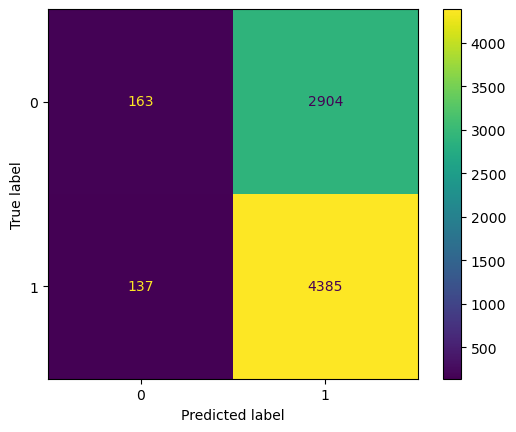

In [239]:
report = metrics.classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)

#confusion matrix
confusionmatrix = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
disp.plot()
plt.show()

### Estimator 2: XGBoost

In [17]:
xgb_model = xgb.XGBClassifier(objective='reg:logistic', num_class=3)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

report = metrics.classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)

#confusion matrix
confusionmatrix = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
disp.plot()
plt.show()

AttributeError: module 'xgboost' has no attribute 'XGBClassifier'

### Estimator 3: Nueral Network

In [161]:
X_train, X_test, y_train, y_test = data_prep(resample_majority=True)


(37945, 16)
(37945,)


In [308]:
# NN Model

columns = ["FG_PCT", "FT_PCT", "OREB", "TOV", "PTS", "FGM"]

X_train, X_test, y_train, y_test = data_prep(resample_majority=True, net_scores=False, columns=columns)

sample_weights = compute_sample_weight('balanced', y=y_train)

# defining the model
NN_model = Sequential([
    Dense(64, input_shape=(12,), activation='relu'),  # Input layer with 12 features
    Dropout(0.01),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.02)),   # Hidden layer
    Dropout(0.01),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.02)),   # Hidden layer
    Dropout(0.01),
    BatchNormalization(),
    Dense(32, activation='relu'),   # Hidden layer
    Dropout(0.01),
    BatchNormalization(),
    # Dense(12, activation='relu', kernel_regularizer=l2(0.01)),   # Hidden layer
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

NN_model.compile(optimizer=optimizer, # optimizer for gradient descent
              loss='binary_crossentropy', # loss function for binary classification
              metrics=['binary_accuracy'])

history = NN_model.fit(X_train, y_train, epochs=30, batch_size=40, validation_split=0.2, verbose=0, sample_weight=sample_weights)
NN_model.estimator_type = "classifier"

# Wrap the Keras model using KerasClassifier
# this is because sklearn needs to be sure that the keras model is a classifier
nn_model_classifier = KerasClassifier(model=NN_model, epochs=30, batch_size=5, validation_split=0.2, verbose=0)
nn_model_classifier._estimator_type = "classifier"

test_loss, test_accuracy = NN_model.evaluate(X_test, y_test)
print('Test accuracy: {}'.format(test_accuracy))
NN_y_pred = NN_model.predict(X_test)

(37945, 12)
(37945,)


/Users/akaman150/Desktop/nba_predictor_development/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - binary_accuracy: 0.5717 - loss: 0.6924
Test accuracy: 0.5729345083236694
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step


238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.38      0.42      3067
           1       0.63      0.71      0.66      4522

    accuracy                           0.57      7589
   macro avg       0.55      0.54      0.54      7589
weighted avg       0.56      0.57      0.56      7589



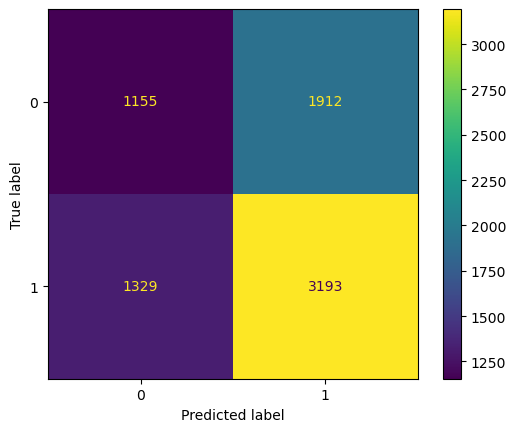

In [309]:
# plt.plot(history.history['binary_accuracy'])
# plt.plot(history.history['val_binary_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# # plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# Set a threshold (e.g., 0.5) to convert probabilities to binary class labels
NN_y_pred = NN_model.predict(X_test)
threshold = 0.50
NN_y_pred = (NN_y_pred >= threshold).astype(int)
report = metrics.classification_report(y_test, NN_y_pred, zero_division=1)
print("Classification Report:")
print(report)

#confusion matrix
confusionmatrix = metrics.confusion_matrix(y_test, NN_y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
disp.plot()
plt.show()

### Estimator 4: 

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.25      0.32      3067
           1       0.61      0.80      0.69      4522

    accuracy                           0.58      7589
   macro avg       0.54      0.53      0.51      7589
weighted avg       0.55      0.58      0.54      7589



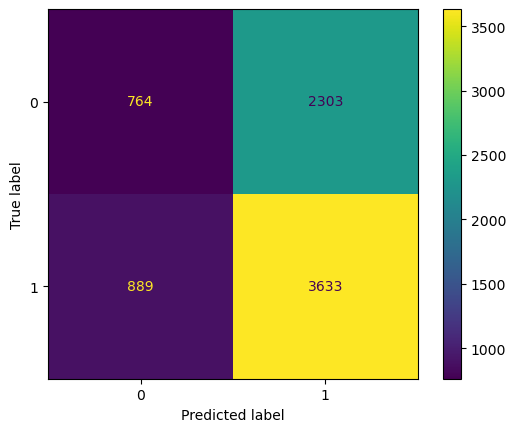

In [120]:
# random forrest regressor


# Create the parameter grid based on the results of random search
# param_grid = {
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'n_estimators': [100, 200, 300, 1000]
# }

rf = RandomForestClassifier()

# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)
# rf_model = grid_search.best_estimator_

rf.fit(X_train, y_train)
rf_y_pred = rf.predict_proba(X_test)[:, 1]

# Set a threshold (e.g., 0.5) to convert probabilities to binary class labels
threshold = 0.52
rf_y_pred = (rf_y_pred >= threshold).astype(int)


report = metrics.classification_report(y_test, rf_y_pred, zero_division=1)
print("Classification Report:")
print(report)

#confusion matrix
confusionmatrix = metrics.confusion_matrix(y_test, rf_y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
disp.plot()
plt.show()

In [221]:
print(X_train)

       FG_PCT_NET  FT_PCT_NET  OREB_NET   TOV_NET
842     -0.371317    1.269936 -0.059484  1.301220
6956    -0.023621    0.810422 -1.142863  0.585641
38626   -1.141215    0.873083  0.843331 -1.382203
27231    1.764529    1.520580  0.482205 -1.203308
50494    0.311657   -1.020673 -0.962300 -0.666623
...           ...         ...       ...       ...
23675    1.491339   -1.918815 -0.601173  1.122325
8671    -0.532747    0.072414 -0.240047 -0.129939
15402   -0.085710   -0.944088  0.843331 -0.666623
865      1.342327   -0.401025 -1.865115  0.406746
22039    1.193314   -2.190346  0.843331  0.943431

[30356 rows x 4 columns]


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ................................var_smoothing=1e-10; total time=   0.0s
[CV] END ................................var_smoothing=1e-11; total time=   0.0s
[CV] END ................................var_smoothing=1e-10; total time=   0.1s
[CV] END ................................var_smoothing=1e-11; total time=   0.0s
[CV] END ................................var_smoothing=1e-11; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-10; total time=   0.0s
{'var_smoothing': 1e-10}
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.50      0.47      3067
           1       0.63      0.59      0.61      4522



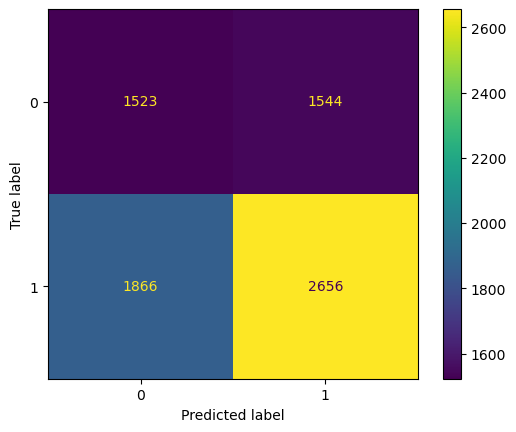

In [300]:
# gaussian naive bayes

sample_weights = compute_sample_weight('balanced', y=y_train)
# class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

gnb_model = GaussianNB()

param_grid = {
    'var_smoothing': [1e-10, 1e-11, 1e-9]
}

grid_search = GridSearchCV(estimator = gnb_model, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2, scoring='accuracy', refit=True)
grid_search.fit(X_train, y_train, sample_weight=sample_weights)
print(grid_search.best_params_)
gnb_model = grid_search.best_estimator_
gnb_y_pred = gnb_model.predict(X_test)


report = metrics.classification_report(y_test, gnb_y_pred, zero_division=1)
print("Classification Report:")
print(report)

#confusion matrix
confusionmatrix = metrics.confusion_matrix(y_test, gnb_y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
disp.plot()
plt.show()

In [216]:
import pickle
filename = 'gnb_4f_20g_model.sav'
pickle.dump(gnb_model, open(filename, 'wb')) 

In [288]:
#load model
loaded_model = pickle.load(open('saved_models/gnb_8f_20g_model.sav', 'rb'))
input = pd.read_csv('test.csv')
input.drop(input.columns[0], axis=1,inplace=True)
print(X_train)

#normalize x_data
scaler = joblib.load("last20_scaler.bin")
input_scaled = scaler.transform(input)

print(input)
prediction = loaded_model.predict_proba(input_scaled)[:,1]
print(prediction)

       FG_PCT_A  FT_PCT_A    OREB_A     TOV_A  FG_PCT_B  FT_PCT_B    OREB_B  \
842    0.255434  2.398454 -0.065790  0.794841  0.791601  0.571744  0.015334   
6956  -0.368271  0.272694 -0.555427  0.290084 -0.343164 -0.861214  1.025731   
38626  0.376710  0.689900 -0.065790  0.290084  2.015021 -0.541703 -1.247661   
27231  1.624120  0.620365  0.423846 -0.719430 -0.857355 -1.509918 -0.237265   
50494 -0.281645 -2.856344 -0.800245  0.037705 -0.733240 -1.364686  0.520533   
...         ...       ...       ...       ...       ...       ...       ...   
23675  1.381568 -1.078255 -0.310608  0.290084 -0.715510  1.617416  0.520533   
8671   1.121691  0.868702 -0.310608 -0.467052  1.908637  0.746023  0.015334   
15402  0.359385 -0.909387  0.668664 -1.476566  0.490179  0.426512 -0.489864   
865    0.116833  0.670033 -0.310608  0.290084 -1.797083  1.210766  2.288726   
22039  1.346917 -0.700784  0.179028  2.056734 -0.325434  2.362942 -0.995062   

          TOV_B  
842   -1.021747  
6956  -0.526266

/Users/akaman150/Desktop/nba_predictor_development/.conda/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.08      0.14      3067
           1       0.60      0.95      0.74      4522

    accuracy                           0.60      7589
   macro avg       0.57      0.52      0.44      7589
weighted avg       0.57      0.60      0.50      7589



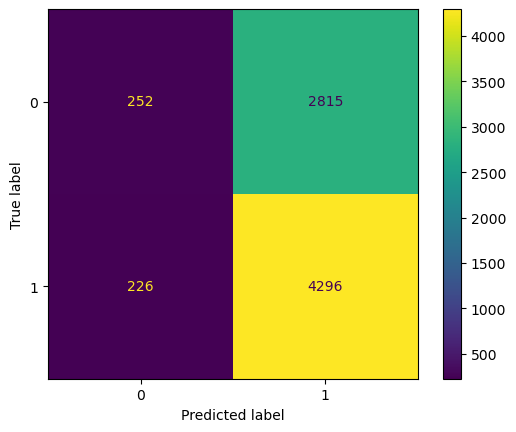

In [124]:
# svm
svm = SVC()
svm.fit(X_train, y_train)
svm_y_pred = svm.predict(X_test)

report = metrics.classification_report(y_test, svm_y_pred, zero_division=1)
print("Classification Report:")
print(report)

#confusion matrix
confusionmatrix = metrics.confusion_matrix(y_test, svm_y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
disp.plot()
plt.show()

In [254]:
# knn
X_train, X_test, y_train, y_test = data_prep(resample_majority=True)

(37945, 8)
(37945,)


{'metric': 'minkowski', 'n_neighbors': 70, 'p': 1, 'weights': 'distance'}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.52      0.47      3067
           1       0.62      0.54      0.58      4522

    accuracy                           0.53      7589
   macro avg       0.53      0.53      0.52      7589
weighted avg       0.55      0.53      0.53      7589



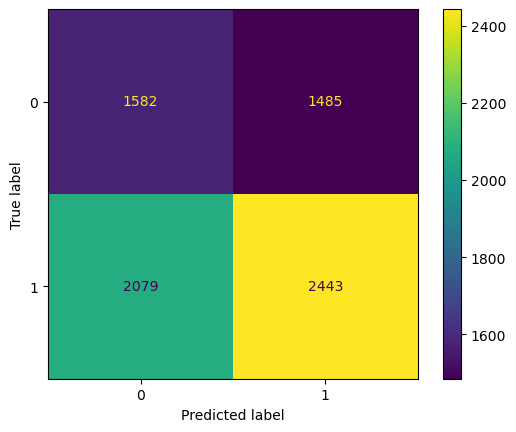

In [253]:

from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [65, 70, 75, 80, 85, 90],
    'p' : [1, 2],
    'weights' : ['uniform', 'distance'],
    'metric' : ['minkowski', 'euclidean', 'manhattan']
}
grid_search = GridSearchCV(estimator = knn_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 0, scoring='accuracy')

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
knn_model = grid_search.best_estimator_

knn_y_pred = knn_model.predict(X_test)

# Set a threshold
# threshold = 0.50
# knn_y_pred = (knn_y_pred >= threshold).astype(int)

report = metrics.classification_report(y_test, knn_y_pred, zero_division=1)
print("Classification Report:")
print(report)

#confusion matrix
confusionmatrix = metrics.confusion_matrix(y_test, knn_y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
disp.plot()
plt.show()

## Ensemble model

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3098
           1       0.84      0.85      0.84      3164

    accuracy                           0.84      6262
   macro avg       0.84      0.84      0.84      6262
weighted avg       0.84      0.84      0.84      6262



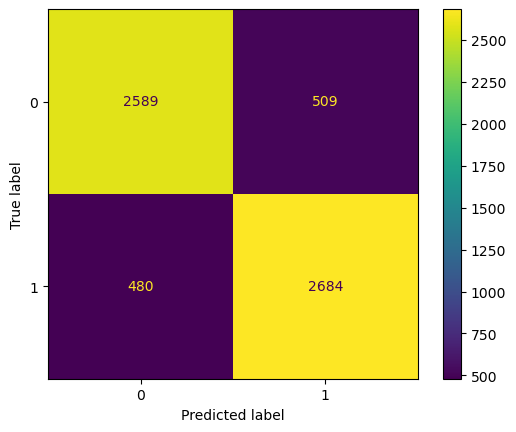

In [13]:
# Using the sklearn Voting Classifier

# logistic_model = sklearn.linear_model.LogisticRegression()
# gnb = GaussianNB()
# svm = SVC()
# rf = RandomForestClassifier()

# Create the Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('ler', lr_model), ('gnb', gnb), ('rf', rf)],
    voting='soft'  # Use 'soft' for probability-based voting
)

# voting_clf.fit(X_train, y_train)
# voting_y_pred = voting_clf.predict(X_test)

# Set a threshold (e.g., 0.5) to convert probabilities to binary class labels
# threshold = 0.5
# voting_y_pred = (voting_y_pred >= threshold).astype(int)
# report = metrics.classification_report(y_test, voting_y_pred, zero_division=1)
# print("Classification Report:")
# print(report)

#confusion matrix
# confusionmatrix = metrics.confusion_matrix(y_test, voting_y_pred)
# disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
# disp.plot()
# plt.show()

In [255]:
# Using seperately trained models
X_train, X_test, y_train, y_test = data_prep(resample_majority=False)


(37945, 8)
(37945,)


238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.41      0.43      3067
           1       0.63      0.67      0.65      4522

    accuracy                           0.57      7589
   macro avg       0.54      0.54      0.54      7589
weighted avg       0.56      0.57      0.56      7589



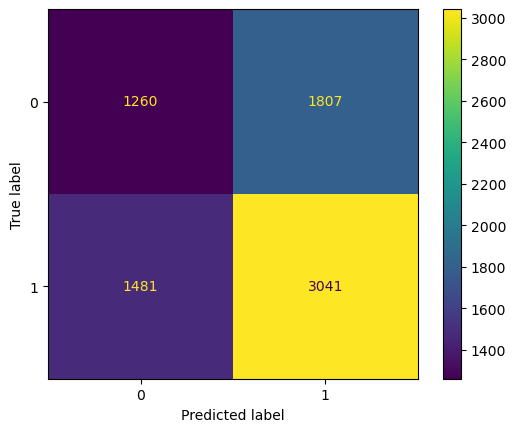

In [305]:
# Predict probabilities
lr_probs = lr_model.predict_proba(X_test)[:, 1]
kn_probs = knn_model.predict_proba(X_test)[:, 1]
nn_probs = NN_model.predict(X_test).flatten()

# Define different thresholds
lr_threshold = 0.5
knn_threshold = 0.5
nn_threshold = 0.5

# Apply thresholds
lr_pred = (lr_probs >= lr_threshold).astype(int)
kn_pred = (kn_probs >= knn_threshold).astype(int)
nn_pred = (nn_probs >= nn_threshold).astype(int)

# Combine predictions using majority voting
combined_pred = (lr_pred + knn_threshold + nn_pred) >= 2  # Majority voting

# Evaluate the combined predictions
report = metrics.classification_report(y_test, combined_pred, zero_division=1)
print("Classification Report:")
print(report)

#confusion matrix
confusionmatrix = metrics.confusion_matrix(y_test, combined_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusionmatrix)
disp.plot()
plt.show()